The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.13.2 -f https://d2l.ai/whl.html # installing d2l


**Note:** Please check out the previous notebooks in chapter 6 of the book, as well as watching the lecture video and slides from this week about Convolutional Neural Networks. 

# Convolutional Neural Networks (LeNet)

We now have all the ingredients required to assemble
a fully-functional convolutional neural network.
In our first encounter with image data,
we applied a multilayer perceptron to pictures of clothing in the Fashion-MNIST dataset.
To make this data amenable to multilayer perceptrons,
we first flattened each image from a $28\times28$ matrix
into a fixed-length $784$-dimensional vector,
and thereafter processed them with fully-connected layers.
Now that we have a handle on convolutional layers,
we can retain the spatial structure in our images.
As an additional benefit of replacing dense layers with convolutional layers, 
we will enjoy more parsimonious models (requiring far fewer parameters).

In this section, we will introduce LeNet,
among the first published convolutional neural networks
to capture wide attention for its performance on computer vision tasks.
The model was introduced (and named for) Yann Lecun,
then a researcher at AT&T Bell Labs,
for the purpose of recognizing handwritten digits in images 
[LeNet5](http://yann.lecun.com/exdb/lenet/).
This work represented the culmination
of a decade of research developing the technology.
In 1989, LeCun published the first study to successfully
train convolutional neural networks via backpropagation. 


At the time LeNet achieved outstanding results 
matching the performance of Support Vector Machines (SVMs),
then a dominant approach in supervised learning.
LeNet was eventually adapted to recognize digits 
for processing deposits in ATM machines.
To this day, some ATMs still run the code 
that Yann and his colleague Leon Bottou wrote in the 1990s!


## LeNet

At a high level, LeNet consists of three parts:
(i) a convolutional encoder consisting of two convolutional layers; and
(ii) a dense block consisting of three fully-connected layers;
The architecture is summarized in :numref:`img_lenet`.

![Data flow in LeNet 5. The input is a handwritten digit, the output a probability over 10 possible outcomes.](http://d2l.ai/_images/lenet.svg)
:label:`img_lenet`

The basic units in each convolutional block 
are a convolutional layer, a sigmoid activation function,
and a subsequent average pooling operation.
Note that while ReLUs and max-pooling work better,
these discoveries had not yet been made in the 90s. 
Each convolutional layer uses a $5\times 5$ kernel
and a sigmoid activation function.
These layers map spatially arranged inputs
to a number of 2D feature maps, typically 
increasing the number of channels.
The first convolutional layer has 6 output channels,
while th second has 16.
Each $2\times2$ pooling operation (stride 2) 
reduces dimensionality by a factor of $4$ via spatial downsampling.
The convolutional block emits an output with size given by
(batch size, channel, height, width).

In order to pass output from the convolutional block
to the fully-connected block, 
we must flatten each example in the minibatch.
In other words, we take this 4D input and transform it
into the 2D input expected by fully-connected layers:
as a reminder, the 2D representation that we desire
has uses the first dimension to index examples in the minibatch
and the second to give the flat vector representation of each example.
LeNet's fully-connected layer block has three fully-connected layers,
with 120, 84, and 10 outputs, respectively.
Because we are still performing classification,
the 10-dimensional output layer corresponds
to the number of possible output classes.

While getting to the point where you truly understand
what is going on inside LeNet may have taken a bit of work,
hopefully the following code snippet will convince you
that implementing such models with modern deep learning libraries 
is remarkably simple. 
We need only to instantiate a `Sequential` Block 
and chain together the appropriate layers.

In [2]:
from d2l import torch as d2l
import torch
from torch import nn
from dataclasses import dataclass

class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1,1,28,28)

#Part 1: Architecture    
net = torch.nn.Sequential(
    Reshape(),
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16*5*5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

We took a small liberty with the original model,
removing the Gaussian activation in the final layer.
Other than that, this network matches
the original LeNet5 architecture.

By passing a single-channel (black and white)
$28 \times 28$ image through the net
and printing the output shape at each layer,
we can inspect the model to make sure 
that its operations line up with 
what we expect from :numref:`img_lenet_vert`.

In [3]:
X = torch.randn(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Reshape output shape: 	 torch.Size([1, 1, 28, 28])
Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


Note that the height and width of the representation
at each layer throughout the convolutional block 
is reduced (compared to the previous layer).
The first convolutional layer uses $2$ pixels of padding 
to compensate for the the reduction in height and width
that would otherwise result from using a $5 \times 5$ kernel.
In contrast, the second convolutional layer foregoes padding, 
and thus the height and width are both reduced by $4$ pixels.
As we go up the stack of layers,
the number of channels increases layer-over-layer
from 1 in the input to 6 after the first convolutional layer
and 16 after the second layer.
However, each pooling layer halves the height and width.
Finally, each fully-connected layer reduces dimensionality,
finally emitting an output whose dimension 
matches the number of classes.

![Compressed notation for LeNet5](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/lenet-vert.svg?raw=1)
:label:`img_lenet_vert`

## Data Acquisition and Training

Now that we have implemented the model,
let's run an experiment to see how LeNet fares on Fashion-MNIST.

In [ ]:
batch_size = 256 #Part 1.7
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

While convolutional networks have few parameters,
they can still be more expensive to compute
than similarly deep multilayer perceptrons
because each parameter participates in many more
multiplications.
If you have access to a GPU, this might be a good time
to put it into action to speed up training.

For evaluation, we need to make a slight modification
to the `evaluate_accuracy` function that we described
in :numref:`sec_softmax_scratch`.
Since the full dataset lives on the CPU,
we need to copy it to the GPU before we can compute our models.
This is accomplished via the `as_in_ctx` function
described in :numref:`sec_use_gpu`.

In [5]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save        
    if not device:
        device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)  # num_corrected_examples, num_examples
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        metric.add(d2l.accuracy(net(X), y), sum(y.shape))
    return metric[0] / metric[1]

We also need to update our training function to deal with GPUs.
Unlike the `train_epoch_ch3` defined in :numref:`sec_softmax_scratch`, 
we now need to move each batch of data 
to our designated context (hopefully, the GPU)
prior to making the forward and backward passes.

The training function `train_ch6` is also similar 
to `train_ch3` defined in :numref:`sec_softmax_scratch`. 
Since we will be implementing networks with many layers 
going forward, we will rely primarily on Gluon.
The following train function assumes a Gluon model 
as input and is optimized accordingly. 
We initialize the model parameters 
on the device indicated by `ctx`
using the Xavier initializer.
Just as with MLPs, our loss function is cross-entropy,
and we minimize it via minibatch stochastic gradient descent. 
Since each epoch takes tens of seconds to run, 
we visualize the training loss more frequently.

In [6]:
#@save
# Part 2: Training Details
def train_ch6(net, train_iter, test_iter, num_epochs, lr, 
              device=d2l.try_gpu()):
    """Train and evaluate a model with CPU or GPU."""    
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight) #Part 2.2
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)  # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            net.train()            
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device) 
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l*X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_loss, train_acc = metric[0]/metric[2], metric[1]/metric[2]
            if (i+1) % 50 == 0:
                animator.add(epoch + i/len(train_iter),
                             (train_loss, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))
    print('loss %.3f, train acc %.3f, test acc %.3f' % (
        train_loss, train_acc, test_acc))
    print('%.1f examples/sec on %s' % (
        metric[2]*num_epochs/timer.sum(), device))

Now let us train the model.

loss 0.470, train acc 0.823, test acc 0.821
24092.7 examples/sec on cuda:0


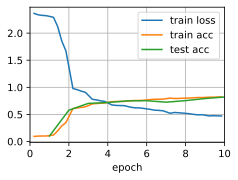

In [7]:
lr, num_epochs = 0.9, 10 #Part 2.1, 2.3
train_ch6(net, train_iter, test_iter, num_epochs, lr)

## Summary

* A ConvNet is a network that employs convolutional layers.
* In a ConvNet, we interleave convolutions, nonlinearities, and (often) pooling operations.
* These convolutional blocks are typically arranged so that they gradually decrease the spatial resolution of the representations, while increasing the number of channels.
* In traditional ConvNets, the representations encoded by the convolutional blocks are processed by one (or more) dense layers prior to emitting output.
* LeNet was arguably the first successful deployment of such a network.


**Exercise:** There are multiple things that can be done to attempt to improve LeNet's accuracy, or any other similar CNN. 

+ Perform the following operations and observe any changes in the accuracy. 
  1. **Architecture**: 
  
    1.1 Replace the average pooling with max pooling.

    1.2 Adjust the convolution window size.

    1.3 Adjust the number of output channels.

    1.4 Adjust the activation function (ReLU?).

    1.5 Adjust the number of convolution layers.

    1.6 Adjust the number of fully connected layers.
  
    1.7 Adjust the batch size. 
  2. **Training Details**: 

    2.1 Adjust the learning rate.

    2.2 Adjust the initialization weights.
  
    2.3 Adjust the number of epochs.

+ **Copy** LeNet architecture and the necessary training functions from above, and then adjust to see what works best on the same FashionMNIST dataset. 

+ You have to create **3** Neural Networks: 

  - One with changes to the Architecture (Choose some adjustments from the list above - a minimum of 2) 
  - One with changes to the Training Details (Choose 2)
  - One with changes to both (Choose 5)

+ **Print** and **Visualize** the improved test accuracy, similar to what's done in the cells above. 

In [ ]:
## Feel free to create multiple code cells below.

loss 0.209, train acc 0.919, test acc 0.892
13816.2 examples/sec on cuda:0


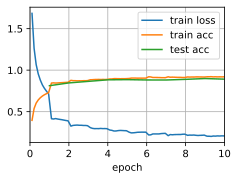

In [9]:
# One with changes to the Architecture (Choose some adjustments from the list above - a minimum of 2)

net1 = torch.nn.Sequential(
    Reshape(),
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(), #change activation function
    nn.MaxPool2d(kernel_size=2, stride=2),   #change to maxpooling
    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16*5*5, 120), nn.ReLU(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

batch_size = 128 #Part 1.7
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

lr, num_epochs = 0.9, 10 #Part 2.1, 2.3
train_ch6(net1, train_iter, test_iter, num_epochs, lr)

loss 0.264, train acc 0.902, test acc 0.890
23479.9 examples/sec on cuda:0


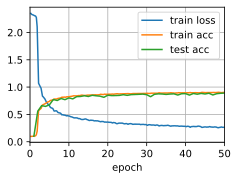

In [20]:
# One with changes to the Training Details (Choose 2)
net2 = torch.nn.Sequential(
    Reshape(),
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(), 
    nn.AvgPool2d(kernel_size=2, stride=2),   
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16*5*5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

batch_size = 256 #Part 1.7
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

lr, num_epochs = 0.8, 50 #Part 2.1, 2.3
train_ch6(net2, train_iter, test_iter, num_epochs, lr)

loss 0.169, train acc 0.935, test acc 0.894
13623.9 examples/sec on cuda:0


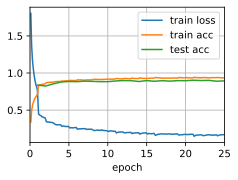

In [21]:
# One with changes to both (Choose 5)
net3 = torch.nn.Sequential(
    Reshape(),
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(), #change activation function
    nn.MaxPool2d(kernel_size=2, stride=2),   #change to maxpooling
    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16*5*5, 120), nn.ReLU(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

batch_size = 128 #Part 1.7
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

#@save
# Part 2: Training Details
def train_ch6_(net, train_iter, test_iter, num_epochs, lr, 
              device=d2l.try_gpu()):
    """Train and evaluate a model with CPU or GPU."""    
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            torch.nn.init.xavier_normal_(m.weight) #Part 2.2
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)  # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            net.train()            
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device) 
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l*X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_loss, train_acc = metric[0]/metric[2], metric[1]/metric[2]
            if (i+1) % 50 == 0:
                animator.add(epoch + i/len(train_iter),
                             (train_loss, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))
    print('loss %.3f, train acc %.3f, test acc %.3f' % (
        train_loss, train_acc, test_acc))
    print('%.1f examples/sec on %s' % (
        metric[2]*num_epochs/timer.sum(), device))
    
lr, num_epochs = 0.8, 25 #Part 2.1, 2.3
train_ch6_(net3, train_iter, test_iter, num_epochs, lr)